In [27]:
import numpy as np
import matplotlib.pyplot as plt
import math
np.random.seed(42)

In [28]:
def get_state(curr_state, drift, days):
    """
    Calculate the next state based on the current state and drift.
    """
    delta = np.random.randint(-drift, drift, dtype=int)
    return max(0, min(curr_state + delta, 2 * days * drift))

In [29]:
def get_reward(curr_state, action, days, drift, start_price, strike_price):
    """
    Calculate the reward based on the current state and action.
    """
    if action == 0:
        return 0
    else:
        return max(0, curr_state - days * drift + start_price - strike_price)

In [30]:
def q_learning(start_price, strike_price, drift, days, df=0.99, num_iter=10000000, lr=0.1):
    epsilon = 1
    epsilon_decay = 0.99  # More gradual decay
    epsilon_min = 0.01
    Q = np.zeros((2 * drift * days + 1, days, 2))

    # Initialize Q-values with a better estimate
    for i in range(2 * drift * days + 1):
        Q[i][days - 1][1] = max(0, i - days * drift + start_price - strike_price)
    start_states=[]
    reward_arr=[]
    for ep in range(num_iter):
        if(ep%10000==0):
            print(ep)
        curr_state = ep % (2 * days * drift + 1)
        i = np.random.randint(0, days - 1)
        reward_curr=0
        start_states.append((curr_state,i))
        while i <days-1:
            next_state = get_state(curr_state, drift, days)
            if np.random.uniform(0, 1) < epsilon:
                action = np.random.choice([0, 1])
            else:
                action = np.argmax(Q[curr_state, i, :])

            # Calculate reward for the taken action
            reward = get_reward(curr_state, action, days, drift, start_price, strike_price)
            # Update Q-values
            if action == 0:
                Q[curr_state, i, action] = (1 - lr) * Q[curr_state, i, action] + lr * (
                            reward + df * np.max(Q[next_state, i + 1]))
            else:
                Q[curr_state, i, action] = (1 - lr) * Q[curr_state, i, action] + lr * (reward)
                reward_curr=reward*math.pow(df,i-start_states[-1][1])
                break
            i += 1
            curr_state = next_state
        epsilon = max(epsilon_min, epsilon * epsilon_decay)  # Gradual decay
        reward_arr.append(reward_curr)

    return Q,start_states,reward_arr

In [31]:
days=10
drift=10
start = 500
strike=510
Q,st,rew = q_learning(start,strike,drift,days)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000
740000
750000
760000
770000
780000
790000
800000
810000
820000
830000
840000
850000
860000
870000
880000
890000
900000
910000
920000
930000
940000
950000
960000
970000
980000
990000
1000000
1010000
1020000
1030000
1040000
1050000
1060000
1070000
1080000
1090000
1100000
1110000
1120000
1130000
1140000
1150000
1160000
1170000
1180000
1190000
1200000
1210000
1220000
1230000
1240000
1250000
1260000
1270000
1280000
1290000
1300000
1310000
1320000
1330000
1340000
1350000
1360000
1370000
1380000
13

In [32]:
arr=[]
for i in range(days):
    curr=[]
    for state in range(0,2*days*drift-1):
        if(Q[state][i][1]>Q[state][i][0]):
            arr.append(state+start-days*drift)
            print("Optimal Stopping for Day:",i+1,"is",state+start-days*drift)
            break

Optimal Stopping for Day: 1 is 515
Optimal Stopping for Day: 2 is 515
Optimal Stopping for Day: 3 is 515
Optimal Stopping for Day: 4 is 515
Optimal Stopping for Day: 5 is 515
Optimal Stopping for Day: 6 is 513
Optimal Stopping for Day: 7 is 513
Optimal Stopping for Day: 8 is 513
Optimal Stopping for Day: 9 is 511
Optimal Stopping for Day: 10 is 511


In [33]:
def transition_probability(drift):
    """
    Calculates the transition probability for the given drift.
    """
    return 1 / (2 * drift + 1)

def get_state(drift):
    """
    Generates a random state within the given drift range.
    """
    return np.random.randint(-drift, drift, dtype=int) 

def value_iteration(gamma=0.99):
    """
    Performs value iteration to find the optimal policy.
    """
    start_price, strike_price = 500, 510
    drift = 10  # Change in stock price on each day
    T = 10  # Number of days till expiry

    V = np.zeros((2 * T * drift + 1, T))
    policy = np.zeros((T, 2 * T * drift + 1))

    # Initialize the value function and policy
    for state in range(2 * T * drift + 1):
        V[state][T - 1] = max(0, state - (strike_price - start_price) - T * drift)
        if V[state][T - 1] > 0:
            policy[T - 1][state] = 1

    # Perform value iteration
    for t in reversed(range(T - 1)):
        Q = np.zeros((2 * T * drift + 1, 2))
        for state in range(2 * T * drift + 1):
            for action in [0, 1]:
                new_value = 0.0
                if action == 0:
                    reward = 0
                    for next_state in range(state - drift, state + drift):
                        if 0 <= next_state <= 2 * T * drift:
                            new_value += transition_probability(drift) * (reward + gamma * V[next_state][t + 1])
                else:
                    reward = max(0, state - (strike_price - start_price) - T * drift)
                    new_value = reward
                Q[state][action] = new_value
            V[state][t] = max(Q[state])
            # Update policy based on Q values
            if Q[state][0] >= Q[state][1]:
                policy[t][state] = 0
            else:
                policy[t][state] = 1
    return V

In [34]:
V = value_iteration()

In [35]:
regrets=[]
for i in range(0,len(st)):
    if len(regrets) == 0:
        regrets.append(V[st[i]] - rew[i])
    else:
        regrets.append(V[st[i]] - rew[i])

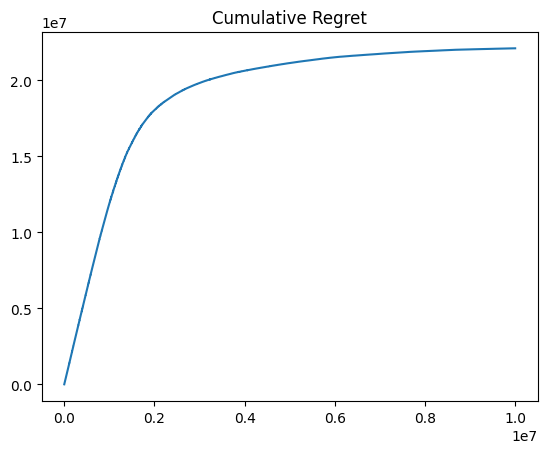

In [36]:
arr_tot = []
for i in range(len(regrets)):
    if(i==0):
        arr_tot.append(regrets[i])
    else:
        arr_tot.append(arr_tot[-1]+regrets[i])
plt.plot(arr_tot)
plt.title("Cumulative Regret")
plt.show()

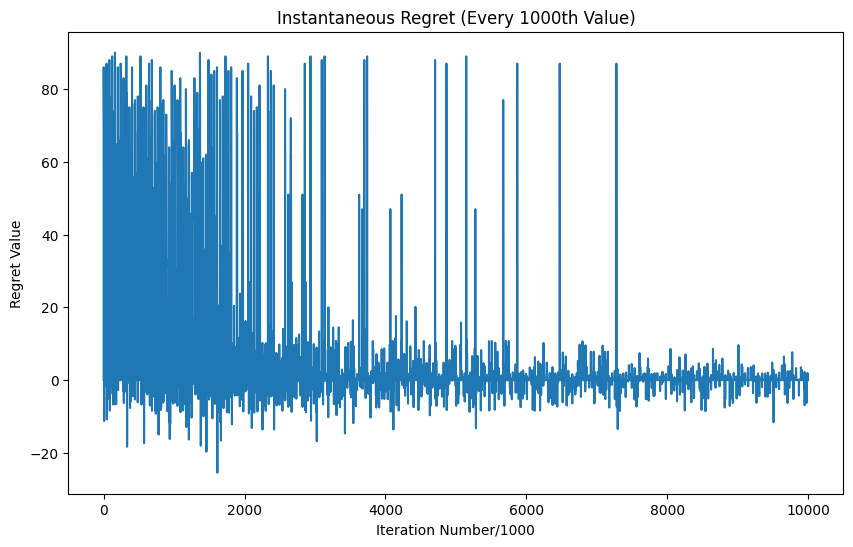

In [37]:
regrets_downsampled = regrets[::1000]

plt.figure(figsize=(10, 6))
plt.plot(regrets_downsampled)
plt.title("Instantaneous Regret (Every 1000th Value)")
plt.xlabel("Iteration Number/1000")
plt.ylabel("Regret Value")
plt.show()

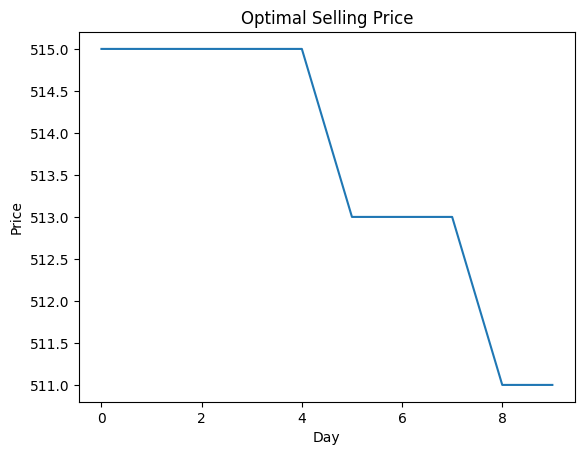

In [38]:
plt.plot(arr)
plt.title("Optimal Selling Price")
plt.xlabel("Day")
plt.ylabel("Price")
plt.show()